In [90]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from datetime import timezone, datetime
import seaborn as sns
from matplotlib import pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [91]:
imputedMeasurementsDf = pd.read_csv('../../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')
measurementsDf = pd.read_csv('../../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [92]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [93]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [94]:
%%time

iso8601ToDatetime()

CPU times: total: 12 s
Wall time: 12.6 s


In [95]:
measurementsDf = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))

In [96]:
measurementsDf.head(20)

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
5,2020-07-14 19:00:00,30.647222,1585.713833,29.133333,101.567130,400.000000,D0001
6,2020-07-14 20:00:00,29.891429,1585.713833,28.597143,101.567130,400.000000,D0001
7,2020-07-14 21:00:00,29.118919,1585.713833,29.162162,101.567130,400.000000,D0001
8,2020-07-14 22:00:00,28.200000,1585.713833,31.611111,101.567130,400.000000,D0001
9,2020-07-14 23:00:00,28.280556,1389.856833,32.111111,101.296439,441.916667,D0001


In [97]:
measurementsDf.index =measurementsDf['time']

<AxesSubplot:xlabel='time'>

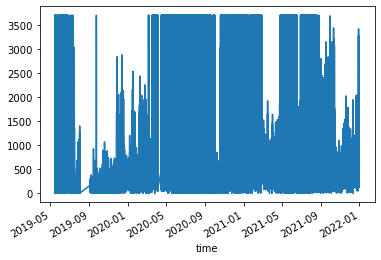

In [98]:
measurementsDf['Rn'].plot()

In [99]:
RadonDf =pd.DataFrame( measurementsDf['Rn'])
RadonDf 

,Rn
time,
2020-07-14 14:00:00,1001.448424
2020-07-14 15:00:00,588.154974
2020-07-14 16:00:00,0.100000
2020-07-14 17:00:00,1042.843803
2020-07-14 18:00:00,1585.713833
...,...
2021-12-31 19:00:00,616.640000
2021-12-31 20:00:00,541.380000
2021-12-31 21:00:00,544.167273


In [100]:
RadonDf['H'] = measurementsDf['H']
RadonDf['CO2'] = measurementsDf['CO2']
RadonDf['P'] = measurementsDf['P']
RadonDf['T'] = measurementsDf['T']
RadonDf

,Rn,H,CO2,P,T
time,,,,,
2020-07-14 14:00:00,1001.448424,44.475000,567.750000,101.565847,31.300000
2020-07-14 15:00:00,588.154974,45.505556,636.361111,101.632854,31.333333
2020-07-14 16:00:00,0.100000,47.145714,734.000000,101.539128,31.451429
2020-07-14 17:00:00,1042.843803,36.000000,461.529412,101.501998,31.161765
2020-07-14 18:00:00,1585.713833,28.436111,400.000000,101.567130,31.008333
...,...,...,...,...,...
2021-12-31 19:00:00,616.640000,50.156364,97.200000,102.653100,29.792673
2021-12-31 20:00:00,541.380000,48.047273,97.800000,102.273400,29.951673
2021-12-31 21:00:00,544.167273,53.847273,97.181818,102.199727,30.329218


In [101]:
from sklearn.metrics import mean_squared_error as mse

def predictions_plotter(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [102]:
#Converts the Df to a numpy array and then extracts the X and y value
#on the required format to train the model
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy() # converts the dataframe to a numpy array
    #Initialized  arrays to append X and Y values 
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        #window row
        row =  [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        #The final output/value
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [103]:
X1, y1 = df_to_X_y(RadonDf)
X1.shape, y1.shape

((115628, 6, 5), (115628,))

In [104]:
X_train, y_train = X1[:92508], y1[:92508] # training data
X_val, y_val = X1[92508:95508], y1[92508:95508] #validation
X_test, y_test = X1[95508:], y1[95508:] #test
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((92508, 6, 5), (92508,), (3000, 6, 5), (3000,), (20120, 6, 5), (20120,))

<h2> <font color='red'>Convolutional neural network implementation </font> <h2/>  

In [105]:
model = Sequential()
model.add(InputLayer((6, 5)))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(2, 'linear'))
model.summary()


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5, 64)             704       
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2568      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 3,290
Trainable params: 3,290
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5, 64)             704       
______________________________

In [106]:
cp = ModelCheckpoint('convolutionalNN_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.0001), 
              metrics=[RootMeanSquaredError()])
print(len(X_train))
print(len(y_train))

92508
92508


In [107]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
2891/2891 [==============================] - 9s 3ms/step - loss: 100678.2656 - root_mean_squared_error: 317.2984 - val_loss: 11399.7090 - val_root_mean_squared_error: 106.7694
INFO:tensorflow:Assets written to: convolutionalNN_model\assets
Epoch 2/10
2891/2891 [==============================] - 8s 3ms/step - loss: 38037.4297 - root_mean_squared_error: 195.0319 - val_loss: 9696.5967 - val_root_mean_squared_error: 98.4713
INFO:tensorflow:Assets written to: convolutionalNN_model\assets
Epoch 3/10
2891/2891 [==============================] - 8s 3ms/step - loss: 36786.5547 - root_mean_squared_error: 191.7982 - val_loss: 9742.8174 - val_root_mean_squared_error: 98.7057
Epoch 4/10
2891/2891 [==============================] - 8s 3ms/step - loss: 36247.8203 - root_mean_squared_error: 190.3886 - val_loss: 9271.8857 - val_root_mean_squared_error: 96.2906
INFO:tensorflow:Assets written to: convolutionalNN_model\assets
Epoch 5/10
2891/2891 [==============================] - 8s 3ms/step -

In [108]:
model = load_model('convolutionalNN_model/')

In [112]:
model

In [114]:
train_predictions = model.predict(X_train)
print(len(X_train))
print(len(y_train))
print(len(train_predictions))
print(train_predictions)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results


92508
92508
92508
[[1477.1595  1377.2998 ]
 [1494.5056  1447.2468 ]
 [1505.2402  1462.7341 ]
 ...
 [ 428.5497   421.7069 ]
 [ 503.62628  495.9919 ]
 [ 423.49722  414.48965]]


ValueError: Per-column arrays must each be 1-dimensional

In [45]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

NameError: name 'train_results' is not defined

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

In [ ]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])